# Data Exploration for License Plate Recognition (YOLOv8)

This notebook performs **Exploratory Data Analysis (EDA)** on a YOLOv8-formatted dataset.  
It covers:
- Dataset download & structure
- Image and label statistics
- Bounding box analysis
- Class distribution visualization
- Annotated sample visualization

In [1]:
# Install Dependencies
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 13.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [2]:
# Importing Libraries
import os
import yaml
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
from roboflow import Roboflow

In [3]:
# Download Dataset from Roboflow
rf = Roboflow(api_key="Your_API_Key") # Replace with your Roboflow key
project = rf.workspace("roboflow-universe-projects").project("license-plate-recognition-rxg4e")
version = project.version(4)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to License-Plate-Recognition-4 in yolov8:: 100%|██████████| 48488/48488 [00:08<00:00, 5708.45it/s]


In [4]:
# Edit YOLO data.yaml file
%%writefile /content/License-Plate-Recognition-4/data.yaml

# Paths to train/val/test image directories
train: /content/License-Plate-Recognition-4/train/images
val: /content/License-Plate-Recognition-4/valid/images
test: /content/License-Plate-Recognition-4/test/images

# Number of classes
nc: 1

# Class names
names: ['License_Plate']

Overwriting /content/License-Plate-Recognition-4/data.yaml


In [19]:
"""
Load YOLO data.yaml configuration file.
This file defines:
- Train/Val/Test directories
- Number of classes
- Class names
"""
with open("/content/License-Plate-Recognition-4/data.yaml", "r") as f:
    data_config = yaml.safe_load(f)

print("Classes:", data_config["names"])
print("Train images path:", data_config["train"])
print("Validation images path:", data_config["val"])
print("Test images path:", data_config["test"])

Classes: ['License_Plate']
Train images path: /content/License-Plate-Recognition-4/train/images
Validation images path: /content/License-Plate-Recognition-4/valid/images
Test images path: /content/License-Plate-Recognition-4/test/images


In [18]:
def count_images(path: str) -> int:
    """
    Count the number of image files in a directory (recursively).

    Args:
        path (str): Directory path

    Returns:
        int: Total number of images
    """
    return sum([len(files) for _, _, files in os.walk(path)])

print("Number of Train Images:", count_images(data_config["train"]))
print("Number of Validation Images:", count_images(data_config["val"]))
print("Number of Test Images:", count_images(data_config["test"]))

Number of Train Images: 21173
Number of Validation Images: 2046
Number of Test Images: 1019


In [17]:
# YOLO labels: class x_center y_center width height (normalized)
label_dir = data_config["train"].replace("images", "labels")

bbox_widths, bbox_heights, class_ids = [], [], []

for root, _, files in os.walk(label_dir):
    for file in files:
        if file.endswith(".txt"):
            with open(os.path.join(root, file), "r") as f:
                for line in f.readlines():
                    cls, x, y, w, h = map(float, line.strip().split())
                    class_ids.append(int(cls))
                    bbox_widths.append(w)
                    bbox_heights.append(h)

df = pd.DataFrame({
    "class_id": class_ids,
    "bbox_width": bbox_widths,
    "bbox_height": bbox_heights
})
df.head()

,class_id,bbox_width,bbox_height
0,0,0.102253,0.059966
1,0,0.123810,0.064781
2,0,0.248949,0.313927
3,0,0.250000,0.146767
4,0,0.257568,0.226562


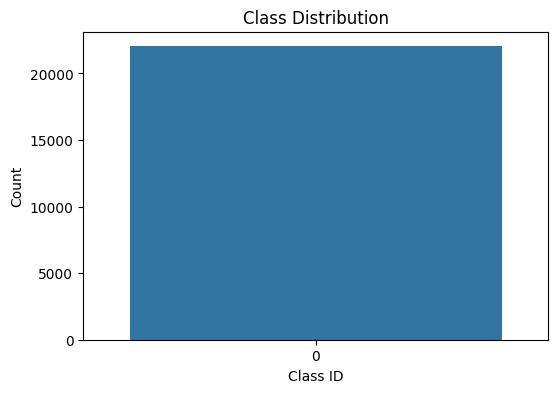

In [13]:
# Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df["class_id"])
plt.title("Class Distribution")
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.show()

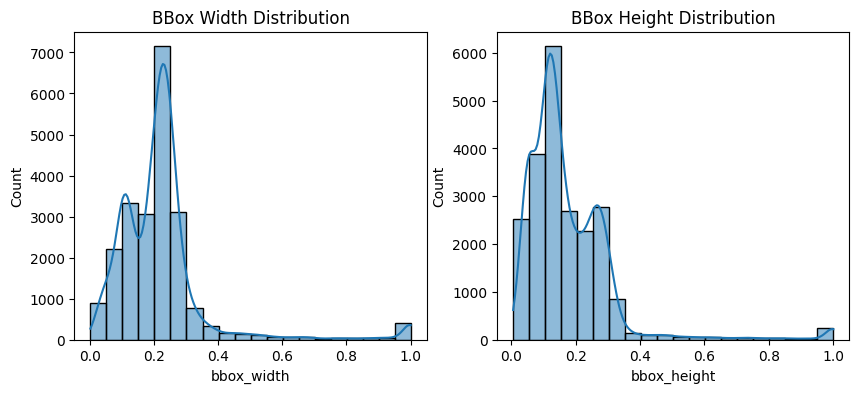

In [14]:
# Bounding Box Stats
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(df["bbox_width"], bins=20, kde=True)
plt.title("BBox Width Distribution")

plt.subplot(1,2,2)
sns.histplot(df["bbox_height"], bins=20, kde=True)
plt.title("BBox Height Distribution")
plt.show()

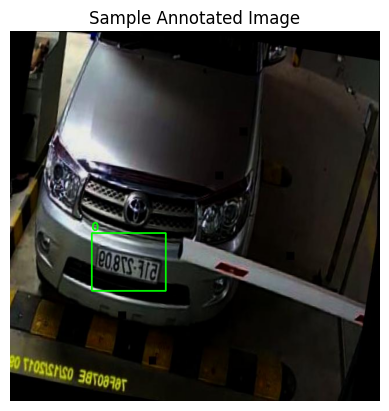

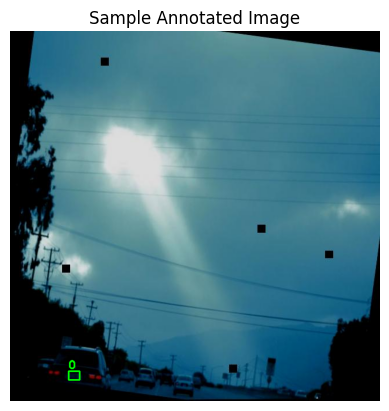

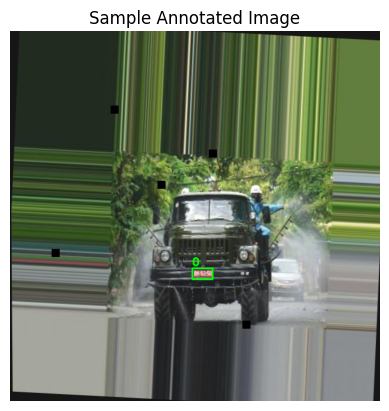

In [16]:
def visualize_random_samples(image_dir: str, n: int = 3):
    """
    Display 'n' random annotated images with bounding boxes.

    Args:
        image_dir (str): Path to training image directory
        n (int): Number of samples to display
    """
    all_images = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".jpg")]

    for _ in range(n):
        img_path = random.choice(all_images)
        img = cv2.imread(img_path)
        h, w, _ = img.shape

        # Get corresponding label file
        label_path = img_path.replace("images", "labels").replace(".jpg", ".txt")
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f.readlines():
                    cls, x, y, bw, bh = map(float, line.strip().split())
                    x1 = int((x - bw/2) * w)
                    y1 = int((y - bh/2) * h)
                    x2 = int((x + bw/2) * w)
                    y2 = int((y + bh/2) * h)
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
                    cv2.putText(img, str(int(cls)), (x1, y1-5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title("Sample Annotated Image")
        plt.show()

# Call visualization
visualize_random_samples(data_config["train"], n=3)